In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import pandas as pd
from shapely.geometry import Point, Polygon

In [2]:
path = 'earthquakes_2023_global.csv'
df = pd.read_csv(path)
df.head(2)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2023-01-01T00:49:25.294Z,52.0999,178.5218,82.770,3.1,ml,14.0,139.0,0.870,0.18,...,2023-03-11T22:51:52.040Z,"Rat Islands, Aleutian Islands, Alaska",earthquake,8.46,21.213,0.097,14.0,reviewed,us,us
1,2023-01-01T01:41:43.755Z,7.1397,126.7380,79.194,4.5,mb,32.0,104.0,1.152,0.47,...,2023-03-11T22:51:45.040Z,"23 km ESE of Manay, Philippines",earthquake,5.51,7.445,0.083,43.0,reviewed,us,us


- 1. Convert the coordinates columns from object to floats 
- 2. Create geometry list from coordinates
- 3. check if any coordinate is missing (if missing, drop)
- 4. Create a geodataframe & save it as a geoJson

In [3]:
# checking if coordinates are floats
# null count = 0 so we can skip step 2
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26642 entries, 0 to 26641
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             26642 non-null  object 
 1   latitude         26642 non-null  float64
 2   longitude        26642 non-null  float64
 3   depth            26642 non-null  float64
 4   mag              26642 non-null  float64
 5   magType          26642 non-null  object 
 6   nst              25227 non-null  float64
 7   gap              25225 non-null  float64
 8   dmin             24776 non-null  float64
 9   rms              26642 non-null  float64
 10  net              26642 non-null  object 
 11  id               26642 non-null  object 
 12  updated          26642 non-null  object 
 13  place            25034 non-null  object 
 14  type             26642 non-null  object 
 15  horizontalError  25093 non-null  float64
 16  depthError       26642 non-null  float64
 17  magError    

In [4]:
# Create Geometry List with list comprehension
geometry_list = [Point(xy) for xy in zip(df["longitude"], df["latitude"])]


In [5]:
# create geodataframe
gdf = gpd.GeoDataFrame(df, crs='epsg:4326', geometry=geometry_list)
gdf.head().T

,0,1,2,3,4
time,2023-01-01T00:49:25.294Z,2023-01-01T01:41:43.755Z,2023-01-01T03:29:31.070Z,2023-01-01T04:09:32.814Z,2023-01-01T04:29:13.793Z
latitude,52.0999,7.1397,19.1631,-4.7803,53.3965
longitude,178.5218,126.738,-66.5251,102.7675,-166.9417
depth,82.77,79.194,24.0,63.787,10.0
mag,3.1,4.5,3.93,4.3,3.0
magType,ml,mb,md,mb,ml
nst,14.0,32.0,23.0,17.0,19.0
gap,139.0,104.0,246.0,187.0,190.0
dmin,0.87,1.152,0.8479,0.457,0.4
rms,0.18,0.47,0.22,0.51,0.31


In [6]:
gdf.to_file("earthquakes_processed.geojson", driver="GeoJSON")

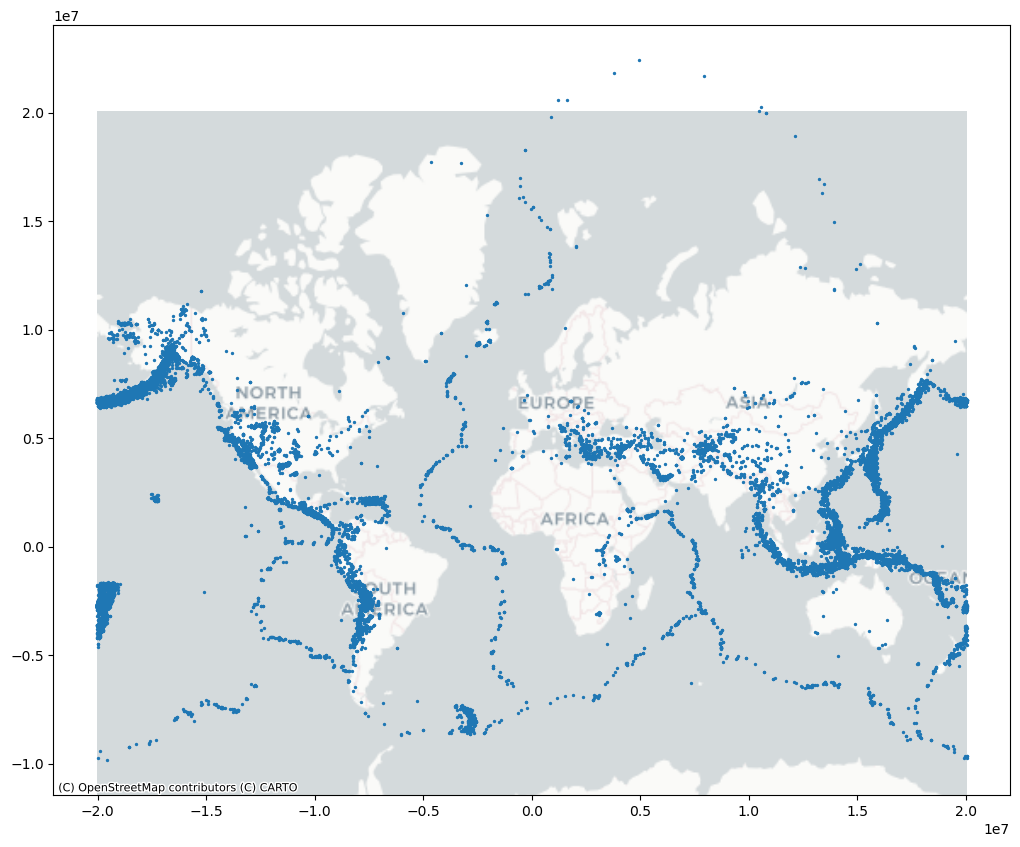

In [12]:
fig, ax = plt.subplots(figsize = (15,10))
gdf.to_crs(epsg=3857).plot(ax = ax, markersize = 2)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

In [13]:
gdf['locationSource']

0        us
1        us
2        pr
3        us
4        us
         ..
26637    us
26638    us
26639    us
26640    us
26641    us
Name: locationSource, Length: 26642, dtype: object

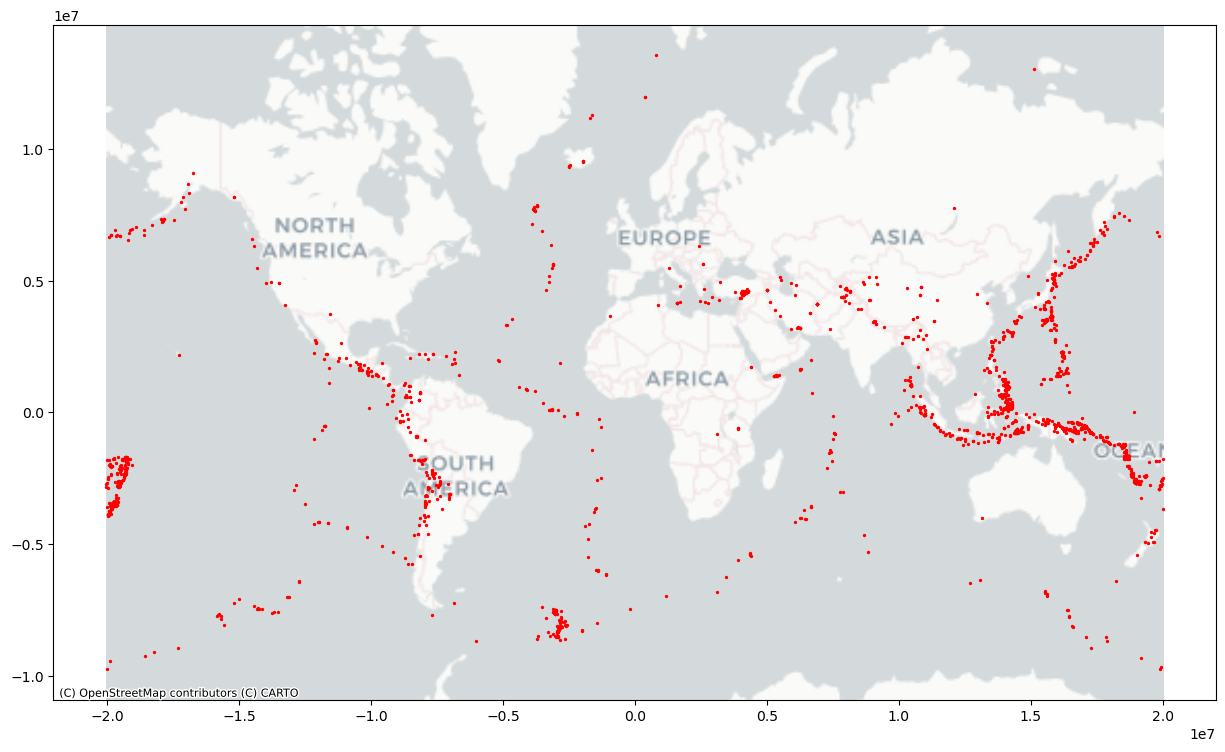

In [26]:
# PLOTTING EARTHQUAKES WITH MAGNITUDE OVER 6.0
magnitude = gdf['mag'] >=6
fig, ax = plt.subplots(figsize = (15,10))
gdf[gdf['mag'] >=5].to_crs(epsg=3857).plot(ax = ax, markersize = 2, color = 'red')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

in this section I wanted to create a new column which classifies each earthquake reading

In [70]:
# first create the column and assign a placement value
# next create a condition for the column based on each value using .loc
# but this works best for binary classification
# gdf['Magnitude_class'] = 'Strong'
# gdf.loc[gdf['mag'] >= 5.0, 'Magnitude_class'] = 'Massive'
# gdf.head()

In [71]:
gdf.drop( columns=['Maginitude_class'])

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,geometry,Magnitude_class
0,2023-01-01T00:49:25.294Z,52.0999,178.5218,82.770,3.10,ml,14.0,139.0,0.8700,0.18,...,earthquake,8.46,21.213,0.097,14.0,reviewed,us,us,POINT (178.52180 52.09990),Minor
1,2023-01-01T01:41:43.755Z,7.1397,126.7380,79.194,4.50,mb,32.0,104.0,1.1520,0.47,...,earthquake,5.51,7.445,0.083,43.0,reviewed,us,us,POINT (126.73800 7.13970),Minor
2,2023-01-01T03:29:31.070Z,19.1631,-66.5251,24.000,3.93,md,23.0,246.0,0.8479,0.22,...,earthquake,0.91,15.950,0.090,16.0,reviewed,pr,pr,POINT (-66.52510 19.16310),Minor
3,2023-01-01T04:09:32.814Z,-4.7803,102.7675,63.787,4.30,mb,17.0,187.0,0.4570,0.51,...,earthquake,10.25,6.579,0.238,5.0,reviewed,us,us,POINT (102.76750 -4.78030),Minor
4,2023-01-01T04:29:13.793Z,53.3965,-166.9417,10.000,3.00,ml,19.0,190.0,0.4000,0.31,...,earthquake,1.41,1.999,0.085,18.0,reviewed,us,us,POINT (-166.94170 53.39650),Micro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26637,2023-12-29T03:37:19.334Z,-6.9527,154.9829,10.000,5.20,mb,72.0,60.0,3.9240,0.93,...,earthquake,10.07,1.765,0.048,141.0,reviewed,us,us,POINT (154.98290 -6.95270),Minor
26638,2023-12-29T04:38:54.109Z,32.3262,141.7386,10.000,5.10,mb,74.0,121.0,1.8030,0.70,...,earthquake,9.17,1.870,0.042,187.0,reviewed,us,us,POINT (141.73860 32.32620),Minor
26639,2023-12-29T08:42:05.747Z,-7.2411,68.0663,10.000,5.10,mb,60.0,54.0,12.7760,0.57,...,earthquake,8.02,1.792,0.090,40.0,reviewed,us,us,POINT (68.06630 -7.24110),Minor
26640,2023-12-29T11:02:48.679Z,-19.1602,169.0428,153.264,4.70,mb,40.0,61.0,3.7460,0.82,...,earthquake,8.52,7.433,0.081,46.0,reviewed,us,us,POINT (169.04280 -19.16020),Minor


In [72]:
# to add multiple conditions

import numpy as np

In [73]:
# create 2 lists one for the conditions and the other for the values
conditions = [
    (gdf['mag'] <= 3),
    (gdf['mag'] >= 3 & (gdf['mag'] <= 4)),
    (gdf['mag'] >= 4 & (gdf['mag'] <= 5)),
    (gdf['mag'] >= 5 & (gdf['mag'] <= 6)),
    (gdf['mag'] >= 6 & (gdf['mag'] <= 7)),
    (gdf['mag'] >= 7 & (gdf['mag'] <= 8)),
    (gdf['mag'] >= 8)    
]
values = [
    'Micro',
    'Minor',
    'Light',
    'Moderate',
    'Strong',
    'Major',
    'Great'
]

In [74]:
gdf['Magnitude_class'] = np.select(conditions, values)
gdf.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,horizontalError,depthError,magError,magNst,status,locationSource,magSource,geometry,Magnitude_class,Maginitude_class
0,2023-01-01T00:49:25.294Z,52.0999,178.5218,82.770,3.10,ml,14.0,139.0,0.8700,0.18,...,8.46,21.213,0.097,14.0,reviewed,us,us,POINT (178.52180 52.09990),Minor,NaN
1,2023-01-01T01:41:43.755Z,7.1397,126.7380,79.194,4.50,mb,32.0,104.0,1.1520,0.47,...,5.51,7.445,0.083,43.0,reviewed,us,us,POINT (126.73800 7.13970),Minor,NaN
2,2023-01-01T03:29:31.070Z,19.1631,-66.5251,24.000,3.93,md,23.0,246.0,0.8479,0.22,...,0.91,15.950,0.090,16.0,reviewed,pr,pr,POINT (-66.52510 19.16310),Minor,NaN
3,2023-01-01T04:09:32.814Z,-4.7803,102.7675,63.787,4.30,mb,17.0,187.0,0.4570,0.51,...,10.25,6.579,0.238,5.0,reviewed,us,us,POINT (102.76750 -4.78030),Minor,NaN
4,2023-01-01T04:29:13.793Z,53.3965,-166.9417,10.000,3.00,ml,19.0,190.0,0.4000,0.31,...,1.41,1.999,0.085,18.0,reviewed,us,us,POINT (-166.94170 53.39650),Micro,NaN


In [75]:
gdf[gdf.loc[:, "mag"] > 5] [['mag', 'Magnitude_class']]

,mag,Magnitude_class
19210,5.4,Minor
19213,5.2,Minor
19215,5.1,Minor
19218,5.5,Minor
19219,5.8,Minor
...,...,...
26633,5.2,Minor
26635,5.7,Minor
26637,5.2,Minor
26638,5.1,Minor


In [76]:
gdf.to_csv("eqks")